In [1]:
!pip install --upgrade xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.1 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.4
    Uninstalling xgboost-2.1.4:
      Successfully uninstalled xgboost-2.1.4


In [2]:
!pip uninstall -y xgboost
!pip install xgboost==1.7.6



Found existing installation: xgboost 3.0.2
Uninstalling xgboost-3.0.2:
  Successfully uninstalled xgboost-3.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 5.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import gc
import time
import warnings
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

# Load Data 
print("Loading data with memory optimization...")

def load_data_with_mem_opt(file_path, chunksize=100000):
    chunks = []
    for chunk in pd.read_csv(file_path, chunksize=chunksize):
        chunks.append(chunk)
    return pd.concat(chunks, axis=0)

train_trans = load_data_with_mem_opt("train_transaction.csv")
train_id = load_data_with_mem_opt("train_identity.csv")
test_trans = load_data_with_mem_opt("test_transaction.csv")
test_id = load_data_with_mem_opt("test_identity.csv")


print("Merging datasets...")
train_df = train_trans.merge(train_id, on='TransactionID', how='left')
test_df = test_trans.merge(test_id, on='TransactionID', how='left')


del train_trans, train_id, test_trans, test_id
gc.collect()

print(f"Train shape: {train_df.shape} | Test shape: {test_df.shape}")


y = train_df['isFraud'].values
test_ids = test_df['TransactionID'].values


train_df = train_df.drop(columns=['TransactionID', 'isFraud'])
test_df = test_df.drop(columns=['TransactionID'])
gc.collect()

# Preprocessing & Feature Reduction

def optimize_memory(df):
    """Optimize memory usage by downcasting numeric columns"""
    for col in df.select_dtypes(include=['int64']):
        df[col] = pd.to_numeric(df[col], downcast='integer')
    for col in df.select_dtypes(include=['float64']):
        df[col] = pd.to_numeric(df[col], downcast='float')
    return df

print("Filling missing values and encoding with memory optimization...")
for df in [train_df, test_df]:
    num_cols = df.select_dtypes(include='number').columns
    for col in num_cols:
        df[col] = df[col].fillna(df[col].median())

    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in cat_cols:
        df[col] = df[col].fillna('missing').astype('category').cat.codes

    df = optimize_memory(df)

print("Aligning train/test columns before feature reduction...")
shared_cols = train_df.columns.intersection(test_df.columns)
train_df = train_df[shared_cols]
test_df = test_df[shared_cols]
gc.collect()

print("Removing low-variance features...")
var_thresh = VarianceThreshold(threshold=0.01)
var_thresh.fit(train_df)
selected_cols = train_df.columns[var_thresh.get_support()]
train_df = train_df[selected_cols]
test_df = test_df[selected_cols]
gc.collect()

print("Removing highly correlated features (chunked for memory)...")
corr_matrix = None
chunk_size = 100
for i in range(0, len(train_df.columns), chunk_size):
    chunk_cols = train_df.columns[i:i + chunk_size]
    chunk_corr = train_df[chunk_cols].corr().abs()
    if corr_matrix is None:
        corr_matrix = chunk_corr
    else:
        corr_matrix = pd.concat([corr_matrix, chunk_corr], axis=1)

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]
train_df.drop(columns=to_drop, inplace=True)
test_df.drop(columns=to_drop, inplace=True)
del corr_matrix, upper
gc.collect()

print("Selecting top 100 features with RandomForest (reduced settings for memory)...")
rf = RandomForestClassifier(n_estimators=30, max_depth=4, n_jobs=-1, random_state=42, max_samples=0.5)
rf.fit(train_df, y)
importances = rf.feature_importances_

imp_df = pd.DataFrame({'feature': train_df.columns, 'importance': importances})
imp_df = imp_df.sort_values(by='importance', ascending=False).head(100)
top_features = imp_df['feature'].tolist()

with open('selected_features.txt', 'w') as f:
    for feat in top_features:
        f.write(f"{feat}\n")

X = train_df[top_features].copy()
X_test = test_df[top_features].copy()
del train_df, test_df, rf, importances, imp_df
gc.collect()

# Train XGBoost 
print("Training XGBoost with memory optimization...")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

del X
gc.collect()

xgb_clf = XGBClassifier(
    n_estimators=200,  
    max_depth=5,       
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='auc',
    use_label_encoder=False,
    tree_method='hist',
    random_state=42
)

xgb_clf.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=20,
    verbose=True
)

val_preds = xgb_clf.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, val_preds)
print(f"\nValidation ROC AUC: {val_auc:.4f}")

# Predict on Test 
print("Predicting on test set...")
test_preds = xgb_clf.predict_proba(X_test)[:, 1]

submission = pd.DataFrame({
    'TransactionID': test_ids,
    'isFraud': test_preds
})
submission.to_csv("xgb_submission.csv", index=False)
print("Submission saved to 'xgb_submission.csv'")

# Parameter Tuning 
print("\nRunning memory-optimized parameter tuning...")

params_grid = [
    {'max_depth': 5, 'learning_rate': 0.05, 'min_child_weight': 3, 'subsample': 0.7, 'colsample_bytree': 0.7},
    {'max_depth': 5, 'learning_rate': 0.05, 'min_child_weight': 3, 'subsample': 0.9, 'colsample_bytree': 0.8, 'gamma': 1},
    {'max_depth': 5, 'learning_rate': 0.05, 'min_child_weight': 3, 'subsample': 0.8, 'colsample_bytree': 0.9, 'scale_pos_weight': 15}
]

best_score = 0
best_model = None
best_params = None

for params in params_grid:
    print(f"\nTrying params: {params}")

    gc.collect()

    model = XGBClassifier(
        n_estimators=200,  
        eval_metric='auc',
        use_label_encoder=False,
        tree_method='hist',
        random_state=42,
        **params
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=20,
        verbose=False
    )

    preds = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, preds)
    print(f"AUC: {auc:.4f}")

    if auc > best_score:
        best_score = auc
        best_model = model
        best_params = params

    del model
    gc.collect()

print(f"\n✅ Best AUC: {best_score:.4f}")
print(f"✅ Best Parameters: {best_params}")


Loading data with memory optimization...
Merging datasets...
Train shape: (590540, 434) | Test shape: (506691, 433)
Filling missing values and encoding with memory optimization...
Aligning train/test columns before feature reduction...
Removing low-variance features...
Removing highly correlated features (chunked for memory)...
Selecting top 100 features with RandomForest (reduced settings for memory)...
Training XGBoost with memory optimization...
[0]	validation_0-auc:0.76379
[1]	validation_0-auc:0.76480
[2]	validation_0-auc:0.78392
[3]	validation_0-auc:0.78774
[4]	validation_0-auc:0.78919
[5]	validation_0-auc:0.78960
[6]	validation_0-auc:0.79006
[7]	validation_0-auc:0.80178
[8]	validation_0-auc:0.80155
[9]	validation_0-auc:0.80349
[10]	validation_0-auc:0.80383
[11]	validation_0-auc:0.81325
[12]	validation_0-auc:0.82037
[13]	validation_0-auc:0.81949
[14]	validation_0-auc:0.81976
[15]	validation_0-auc:0.81978
[16]	validation_0-auc:0.82106
[17]	validation_0-auc:0.82111
[18]	validation_0

Loading data...
Train shape: (144233, 434) | Test shape: (506691, 433)
Adding behavioral features...
Feature selection...

Training LightGBM with class weights...
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's auc: 0.95963
LightGBM Val AUC: 0.9596

Training PyTorch NN as ensemble...
Epoch 1, Loss: 0.7718
Epoch 2, Loss: 0.7201
Epoch 3, Loss: 0.6936

Generating SHAP explanations...


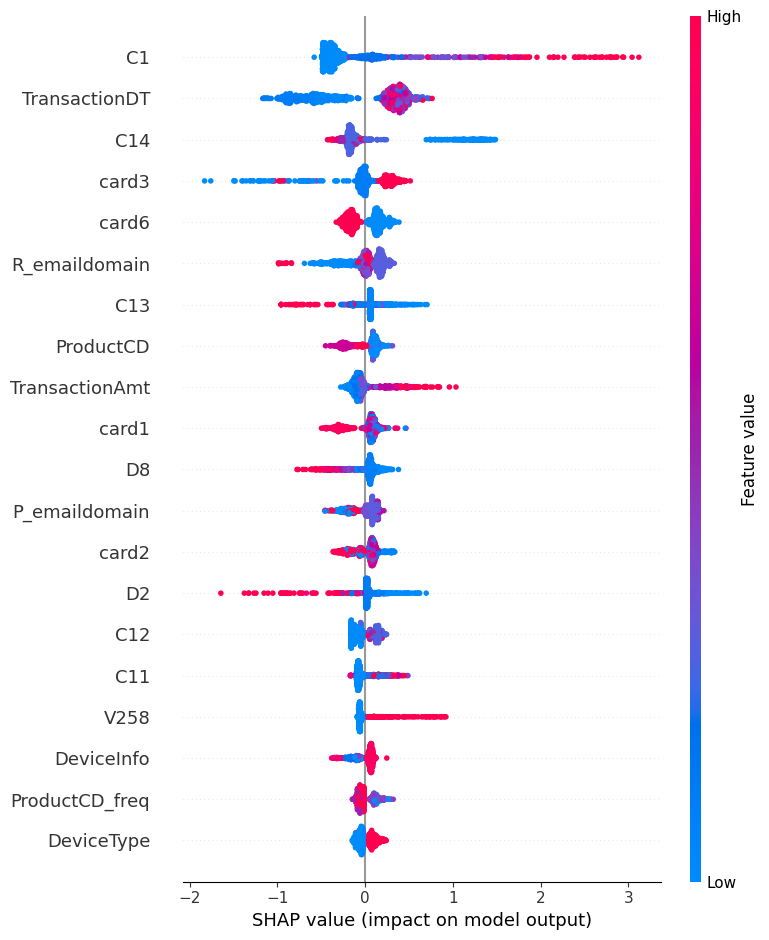


Done! Final submission saved as 'advanced_ensemble_submission.csv'.


In [ ]:
import pandas as pd
import numpy as np
import gc
import warnings
import os
import joblib
import lightgbm as lgb
import shap
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

warnings.filterwarnings('ignore')

def load_data_in_batches(file_path, usecols=None, dtype=None, chunksize=50000):
    chunks = []
    for chunk in pd.read_csv(file_path, usecols=usecols, dtype=dtype, chunksize=chunksize):
        chunk = chunk.dropna(axis=1, how='all')
        chunks.append(chunk)
        del chunk
        gc.collect()
    return pd.concat(chunks, axis=0)

def load_filtered_data(file_path, filter_ids):
    chunks = []
    for chunk in pd.read_csv(file_path, chunksize=50000):
        chunk = chunk[chunk['TransactionID'].isin(filter_ids)]
        if not chunk.empty:
            chunks.append(chunk)
        del chunk
        gc.collect()
    return pd.concat(chunks, axis=0) if chunks else pd.DataFrame()

print("Loading data...")
base_cols = ['TransactionID', 'isFraud']
train_trans = load_data_in_batches("train_transaction.csv", usecols=base_cols)
train_id = load_data_in_batches("train_identity.csv", usecols=['TransactionID'])

train_df = train_trans.merge(train_id, on='TransactionID', how='inner')
required_ids = train_df['TransactionID'].unique()
del train_trans, train_id, train_df
gc.collect()

train_trans = load_filtered_data("train_transaction.csv", required_ids)
train_id = load_filtered_data("train_identity.csv", required_ids)
train_df = train_trans.merge(train_id, on='TransactionID', how='left')

test_trans = load_data_in_batches("test_transaction.csv")
test_id = load_data_in_batches("test_identity.csv")
test_df = test_trans.merge(test_id, on='TransactionID', how='left')

del train_trans, train_id, test_trans, test_id
gc.collect()

print(f"Train shape: {train_df.shape} | Test shape: {test_df.shape}")

# Preprocessing 
y = train_df['isFraud'].values
test_ids = test_df['TransactionID'].values
train_df = train_df.drop(columns=['TransactionID', 'isFraud'])
test_df = test_df.drop(columns=['TransactionID'])

def optimize_numeric(df):
    num_cols = df.select_dtypes(include='number').columns
    for col in num_cols:
        df[col] = pd.to_numeric(df[col], downcast='float')
        df[col] = df[col].fillna(df[col].median())
    return df

def optimize_categorical(df):
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in cat_cols:
        df[col] = df[col].fillna('missing').astype('category').cat.codes
        df[col] = pd.to_numeric(df[col], downcast='integer')
    return df

# Process in chunks
for df in [train_df, test_df]:
    for i in range(0, len(df.columns), 50):
        cols = df.columns[i:i+50]
        temp_df = df[cols]
        temp_df = optimize_numeric(temp_df)
        temp_df = optimize_categorical(temp_df)
        df[cols] = temp_df
        del temp_df
        gc.collect()

# Feature Engineering
print("Adding behavioral features...")
for df in [train_df, test_df]:
    df['TransactionAmt_to_mean'] = df['TransactionAmt'] / (df['TransactionAmt'].mean() + 1e-9)
    df['TransactionAmt_to_std'] = df['TransactionAmt'] / (df['TransactionAmt'].std() + 1e-9)
    # If 'ProductCD' exists
    if 'ProductCD' in df.columns:
        df['ProductCD_freq'] = df.groupby('ProductCD')['ProductCD'].transform('count')
    # Time-based feature (example)
    if 'TransactionDT' in df.columns:
        df['hour'] = (df['TransactionDT'] // 3600) % 24


print("Feature selection...")
shared_cols = train_df.columns.intersection(test_df.columns)
train_df = train_df[shared_cols]
test_df = test_df[shared_cols]

var_thresh = VarianceThreshold(threshold=0.01)
var_thresh.fit(train_df)
selected_cols = train_df.columns[var_thresh.get_support()]
train_df = train_df[selected_cols]
test_df = test_df[selected_cols]


scaler = StandardScaler()
train_df_scaled = scaler.fit_transform(train_df)
test_df_scaled = scaler.transform(test_df)

# LightGBM with Class Weights
print("\nTraining LightGBM with class weights...")
X_train, X_val, y_train, y_val = train_test_split(train_df, y, test_size=0.2, stratify=y, random_state=42)
train_data = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data, free_raw_data=False)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'scale_pos_weight': (len(y_train)-y_train.sum())/y_train.sum(),  # class weight
    'verbose': -1,
    'seed': 42,
    'max_depth': 5
}

lgbm = lgb.train(
    params,
    train_data,
    valid_sets=[val_data],
    callbacks=[lgb.early_stopping(20)],
    num_boost_round=200
)

lgbm_preds = lgbm.predict(X_val)
lgbm_auc = roc_auc_score(y_val, lgbm_preds)
print(f"LightGBM Val AUC: {lgbm_auc:.4f}")

print("\nTraining PyTorch NN as ensemble...")

class FraudNet(nn.Module):
    def __init__(self, input_dim):
        super(FraudNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FraudNet(train_df.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

X_train_torch = torch.tensor(train_df_scaled, dtype=torch.float32).to(device)
y_train_torch = torch.tensor(y, dtype=torch.float32).unsqueeze(1).to(device)


for epoch in range(50):  
    model.train()
    optimizer.zero_grad()
    preds = model(X_train_torch)
    loss = criterion(preds, y_train_torch)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Ensemble Predictions on Test Set 
lgbm_test_preds = lgbm.predict(test_df)
model.eval()
with torch.no_grad():
    test_preds_nn = model(torch.tensor(test_df_scaled, dtype=torch.float32).to(device)).cpu().numpy().flatten()

# Weighted average ensemble
final_test_preds = 0.7 * lgbm_test_preds + 0.3 * test_preds_nn

# SHAP 
print("\nGenerating SHAP explanations...")
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_val[:1000])  # subset for performance
shap.summary_plot(shap_values, X_val.iloc[:1000])

submission = pd.DataFrame({
    'TransactionID': test_ids,
    'isFraud': final_test_preds
})
submission.to_csv("advanced_ensemble_submission.csv", index=False)

print("\nDone! Final submission saved as 'advanced_ensemble_submission.csv'.")


In [ ]:
print("\nTraining PyTorch NN as ensemble...")

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

class FraudNet(nn.Module):
    def __init__(self, input_dim):
        super(FraudNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FraudNet(train_df.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

X_train_torch = torch.tensor(train_df.values, dtype=torch.float32).to(device)
y_train_torch = torch.tensor(y, dtype=torch.float32).unsqueeze(1).to(device)

for epoch in range(50):  
    model.train()
    optimizer.zero_grad()
    preds = model(X_train_torch)
    loss = criterion(preds, y_train_torch)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Calculate AUC
model.eval()
with torch.no_grad():
    train_preds = model(X_train_torch).cpu().numpy().flatten()
    train_auc = roc_auc_score(y, train_preds)
    print(f"Train AUC: {train_auc:.4f}")



Training PyTorch NN as ensemble...
Epoch 1, Loss: 0.7231
Epoch 2, Loss: 0.6833
Epoch 3, Loss: 0.6808
Epoch 4, Loss: 0.6836
Epoch 5, Loss: 0.6793
Epoch 6, Loss: 0.6730
Epoch 7, Loss: 0.6658
Epoch 8, Loss: 0.6611
Epoch 9, Loss: 0.6603
Epoch 10, Loss: 0.6579
Epoch 11, Loss: 0.6553
Epoch 12, Loss: 0.6524
Epoch 13, Loss: 0.6502
Epoch 14, Loss: 0.6492
Epoch 15, Loss: 0.6449
Epoch 16, Loss: 0.6438
Epoch 17, Loss: 0.6411
Epoch 18, Loss: 0.6397
Epoch 19, Loss: 0.6384
Epoch 20, Loss: 0.6352
Epoch 21, Loss: 0.6334
Epoch 22, Loss: 0.6313
Epoch 23, Loss: 0.6284
Epoch 24, Loss: 0.6283
Epoch 25, Loss: 0.6258
Epoch 26, Loss: 0.6241
Epoch 27, Loss: 0.6212
Epoch 28, Loss: 0.6207
Epoch 29, Loss: 0.6181
Epoch 30, Loss: 0.6163
Epoch 31, Loss: 0.6141
Epoch 32, Loss: 0.6135
Epoch 33, Loss: 0.6112
Epoch 34, Loss: 0.6091
Epoch 35, Loss: 0.6069
Epoch 36, Loss: 0.6044
Epoch 37, Loss: 0.6027
Epoch 38, Loss: 0.6003
Epoch 39, Loss: 0.5980
Epoch 40, Loss: 0.5969
Epoch 41, Loss: 0.5961
Epoch 42, Loss: 0.5913
Epoch 4

Loading data...
Train shape: (144233, 434) | Test shape: (506691, 433)
Adding behavioral features...
Feature selection...

Creating balanced and unbalanced training sets...
Random Forest AUC (unbalanced): 0.9208
Random Forest AUC (balanced):   0.9201
XGBoost AUC (unbalanced): 0.9595
XGBoost AUC (balanced):   0.9556
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's auc: 0.95963
LightGBM AUC: 0.9596

Generating SHAP explanations for LightGBM...


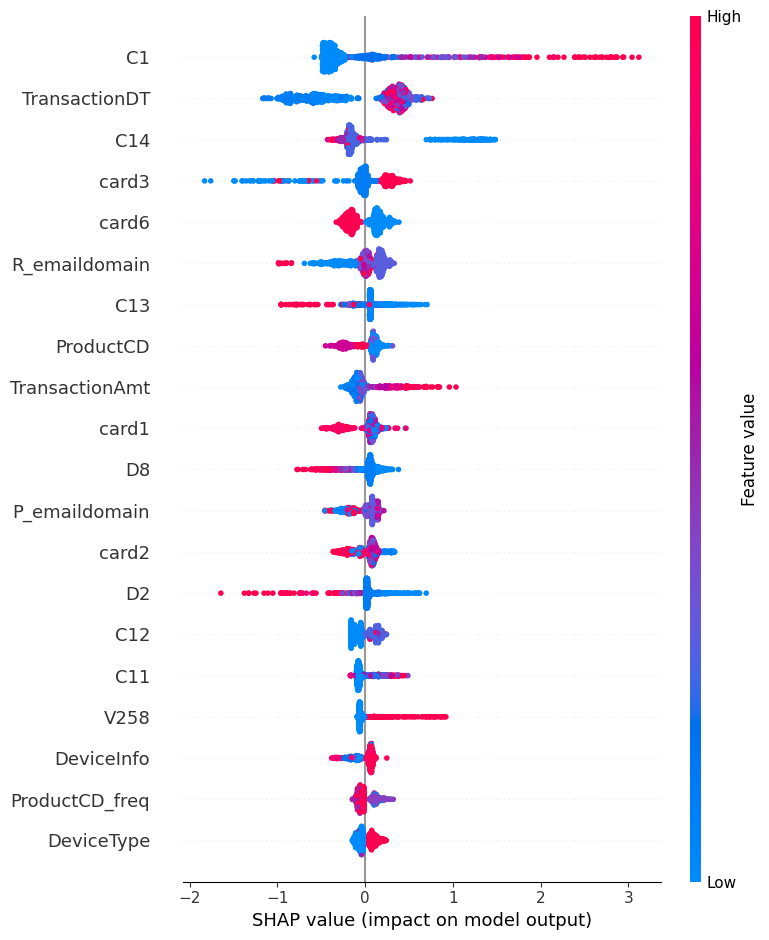


Ensembling predictions for final test predictions...

🎯 Summary of Results:
Random Forest  AUC (unbalanced): 0.9208
Random Forest  AUC (balanced):   0.9201
XGBoost        AUC (unbalanced): 0.9595
XGBoost        AUC (balanced):   0.9556
LightGBM       AUC:              0.9596

Submission saved to 'ensemble_submission.csv'.


In [ ]:
import pandas as pd
import numpy as np
import gc
import warnings
import os
import joblib
import lightgbm as lgb
import shap
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')

def load_data_in_batches(file_path, usecols=None, dtype=None, chunksize=50000):
    chunks = []
    for chunk in pd.read_csv(file_path, usecols=usecols, dtype=dtype, chunksize=chunksize):
        chunk = chunk.dropna(axis=1, how='all')
        chunks.append(chunk)
        del chunk
        gc.collect()
    return pd.concat(chunks, axis=0)

def load_filtered_data(file_path, filter_ids):
    chunks = []
    for chunk in pd.read_csv(file_path, chunksize=50000):
        chunk = chunk[chunk['TransactionID'].isin(filter_ids)]
        if not chunk.empty:
            chunks.append(chunk)
        del chunk
        gc.collect()
    return pd.concat(chunks, axis=0) if chunks else pd.DataFrame()

# Load data
base_cols = ['TransactionID', 'isFraud']
train_trans = load_data_in_batches("train_transaction.csv", usecols=base_cols)
train_id = load_data_in_batches("train_identity.csv", usecols=['TransactionID'])

train_df = train_trans.merge(train_id, on='TransactionID', how='inner')
required_ids = train_df['TransactionID'].unique()
del train_trans, train_id, train_df
gc.collect()

train_trans = load_filtered_data("train_transaction.csv", required_ids)
train_id = load_filtered_data("train_identity.csv", required_ids)
train_df = train_trans.merge(train_id, on='TransactionID', how='left')

test_trans = load_data_in_batches("test_transaction.csv")
test_id = load_data_in_batches("test_identity.csv")
test_df = test_trans.merge(test_id, on='TransactionID', how='left')

del train_trans, train_id, test_trans, test_id
gc.collect()

print(f"Train shape: {train_df.shape} | Test shape: {test_df.shape}")

# Preprocessing 
y = train_df['isFraud'].values
test_ids = test_df['TransactionID'].values
train_df = train_df.drop(columns=['TransactionID', 'isFraud'])
test_df = test_df.drop(columns=['TransactionID'])

def optimize_numeric(df):
    num_cols = df.select_dtypes(include='number').columns
    for col in num_cols:
        df[col] = pd.to_numeric(df[col], downcast='float')
        df[col] = df[col].fillna(df[col].median())
    return df

def optimize_categorical(df):
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in cat_cols:
        df[col] = df[col].fillna('missing').astype('category').cat.codes
        df[col] = pd.to_numeric(df[col], downcast='integer')
    return df

for df in [train_df, test_df]:
    for i in range(0, len(df.columns), 50):
        cols = df.columns[i:i+50]
        temp_df = df[cols]
        temp_df = optimize_numeric(temp_df)
        temp_df = optimize_categorical(temp_df)
        df[cols] = temp_df
        del temp_df
        gc.collect()

# Feature Engineering 
print("Adding behavioral features...")
for df in [train_df, test_df]:
    df['TransactionAmt_to_mean'] = df['TransactionAmt'] / (df['TransactionAmt'].mean() + 1e-9)
    df['TransactionAmt_to_std'] = df['TransactionAmt'] / (df['TransactionAmt'].std() + 1e-9)
    if 'ProductCD' in df.columns:
        df['ProductCD_freq'] = df.groupby('ProductCD')['ProductCD'].transform('count')
    if 'TransactionDT' in df.columns:
        df['hour'] = (df['TransactionDT'] // 3600) % 24

# Feature Selection 
print("Feature selection...")
shared_cols = train_df.columns.intersection(test_df.columns)
train_df = train_df[shared_cols]
test_df = test_df[shared_cols]

var_thresh = VarianceThreshold(threshold=0.01)
var_thresh.fit(train_df)
selected_cols = train_df.columns[var_thresh.get_support()]
train_df = train_df[selected_cols]
test_df = test_df[selected_cols]


scaler = StandardScaler()
train_df_scaled = scaler.fit_transform(train_df)
test_df_scaled = scaler.transform(test_df)


def evaluate_model(model, X_train, X_val, y_train, y_val):
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, preds)
    return auc

# Balanced vs. Unbalanced Data
print("\nCreating balanced and unbalanced training sets...")
X_train, X_val, y_train, y_val = train_test_split(train_df, y, test_size=0.2, stratify=y, random_state=42)

# undersampling
rus = RandomUnderSampler(random_state=42)
X_train_bal, y_train_bal = rus.fit_resample(X_train, y_train)

# oversampling (SMOTE)
smote = SMOTE(random_state=42)
X_train_ovr, y_train_ovr = smote.fit_resample(X_train, y_train)

# Random Forest 
rf = RandomForestClassifier(n_estimators=100, max_depth=7, class_weight='balanced', random_state=42, n_jobs=-1)
rf_auc_unbalanced = evaluate_model(rf, X_train, X_val, y_train, y_val)
rf_auc_balanced = evaluate_model(rf, X_train_bal, X_val, y_train_bal, y_val)
print(f"Random Forest AUC (unbalanced): {rf_auc_unbalanced:.4f}")
print(f"Random Forest AUC (balanced):   {rf_auc_balanced:.4f}")

# XGBoost 
xgb_unbalanced = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, scale_pos_weight=(len(y_train)-y_train.sum())/y_train.sum(), random_state=42, n_jobs=-1, tree_method='hist')
xgb_balanced = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, n_jobs=-1, tree_method='hist')

xgb_auc_unbalanced = evaluate_model(xgb_unbalanced, X_train, X_val, y_train, y_val)
xgb_auc_balanced = evaluate_model(xgb_balanced, X_train_bal, X_val, y_train_bal, y_val)
print(f"XGBoost AUC (unbalanced): {xgb_auc_unbalanced:.4f}")
print(f"XGBoost AUC (balanced):   {xgb_auc_balanced:.4f}")

# LightGBM 
lgb_train_data = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
lgb_val_data = lgb.Dataset(X_val, label=y_val, reference=lgb_train_data, free_raw_data=False)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'seed': 42,
    'max_depth': 5,
    'scale_pos_weight': (len(y_train)-y_train.sum())/y_train.sum()
}
lgbm = lgb.train(params, lgb_train_data, valid_sets=[lgb_val_data], callbacks=[lgb.early_stopping(20)], num_boost_round=200)
lgbm_preds = lgbm.predict(X_val)
lgbm_auc = roc_auc_score(y_val, lgbm_preds)
print(f"LightGBM AUC: {lgbm_auc:.4f}")

# SHAP 
print("\nGenerating SHAP explanations for LightGBM...")
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_val[:1000])
shap.summary_plot(shap_values, X_val.iloc[:1000])

# Final Ensemble: Weighted Average 
print("\nEnsembling predictions for final test predictions...")
rf.fit(X_train, y_train)
rf_test_preds = rf.predict_proba(test_df)[:,1]
xgb_unbalanced.fit(X_train, y_train)
xgb_test_preds = xgb_unbalanced.predict_proba(test_df)[:,1]
lgbm_test_preds = lgbm.predict(test_df)

final_test_preds = 0.4 * lgbm_test_preds + 0.3 * xgb_test_preds + 0.3 * rf_test_preds

submission = pd.DataFrame({
    'TransactionID': test_ids,
    'isFraud': final_test_preds
})
submission.to_csv("ensemble_submission.csv", index=False)

print("\n🎯 Summary of Results:")
print(f"Random Forest  AUC (unbalanced): {rf_auc_unbalanced:.4f}")
print(f"Random Forest  AUC (balanced):   {rf_auc_balanced:.4f}")
print(f"XGBoost        AUC (unbalanced): {xgb_auc_unbalanced:.4f}")
print(f"XGBoost        AUC (balanced):   {xgb_auc_balanced:.4f}")
print(f"LightGBM       AUC:              {lgbm_auc:.4f}")
print("\nSubmission saved to 'ensemble_submission.csv'.")


In [4]:
# === LGBM Submission ===
lgbm_submission = pd.DataFrame({
    'TransactionID': test_ids,
    'isFraud': lgbm_test_preds
})
lgbm_submission.to_csv("lgbm_submission.csv", index=False)

In [6]:
# === XGB Submission ===
xgb_submission = pd.DataFrame({
    'TransactionID': test_ids,
    'isFraud': xgb_test_preds
})
xgb_submission.to_csv("xgb_submission.csv", index=False)

In [13]:
final_test_preds = 0.4 * xgb_test_preds + 0.3 * lgbm_test_preds + 0.3 * rf_test_preds

# === Submission ===
submission = pd.DataFrame({
    'TransactionID': test_ids,
    'isFraud': final_test_preds
})
submission.to_csv("ensemble_submission_v3.csv", index=False)

In [14]:
# === Final Kaggle submission block (Colab) ===

# Upload kaggle.json (only once!)
from google.colab import files
files.upload()  # Select kaggle.json from your computer

# Set up Kaggle API credentials
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Install Kaggle API
!pip install -q kaggle

# Submit the file
!kaggle competitions submit -c ieee-fraud-detection -f ensemble_submission_v3.csv -m "ensemble 3.0"

# Check submission status
!kaggle competitions submissions -c ieee-fraud-detection


Saving kaggle.json to kaggle.json
100% 13.4M/13.4M [00:00<00:00, 19.3MB/s]
Successfully submitted to IEEE-CIS Fraud DetectionfileName                    date                        description   status                     publicScore  privateScore  
--------------------------  --------------------------  ------------  -------------------------  -----------  ------------  
ensemble_submission_v3.csv  2025-06-01 19:18:50.053000  ensemble 3.0  SubmissionStatus.COMPLETE  0.877631     0.859721      
ensemble_submission_v2.csv  2025-06-01 19:15:55.060000  ensemble 2.0  SubmissionStatus.COMPLETE  0.877072     0.856850      
xgb_submission.csv          2025-06-01 19:09:12.577000  xgb           SubmissionStatus.COMPLETE  0.874900     0.853345      
lgbm_submission.csv         2025-06-01 19:06:50.870000  Lgbm          SubmissionStatus.COMPLETE  0.871766     0.847134      
ensemble_submission.csv     2025-06-01 19:03:32.520000  Colab test    SubmissionStatus.COMPLETE  0.877173     0.859085      


Loading data...
Train shape: (144233, 434) | Test shape: (506691, 433)
Adding behavioral features...
Feature selection...

Creating balanced and unbalanced training sets...
Random Forest AUC (unbalanced): 0.9208
Random Forest AUC (balanced):   0.9201
XGBoost AUC (unbalanced): 0.9595
XGBoost AUC (balanced):   0.9556
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's auc: 0.95963
LightGBM AUC: 0.9596

Generating SHAP explanations for LightGBM...


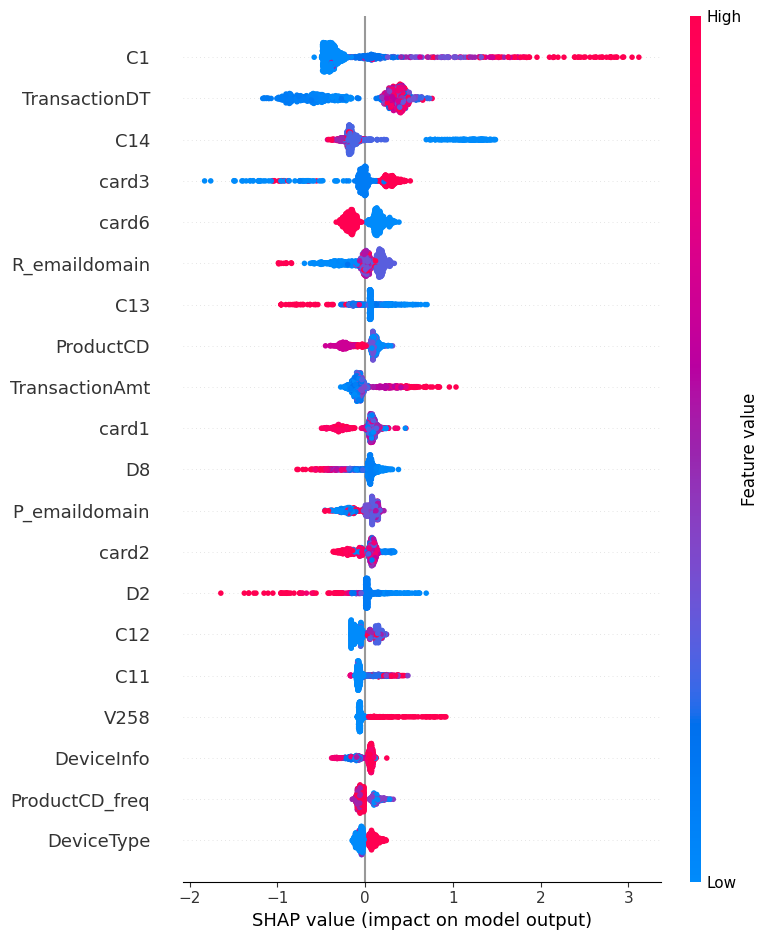


Ensembling predictions for final test predictions...

🎯 Summary of Results:
Random Forest  AUC (unbalanced): 0.9208
Random Forest  AUC (balanced):   0.9201
XGBoost        AUC (unbalanced): 0.9595
XGBoost        AUC (balanced):   0.9556
LightGBM       AUC:              0.9596

Submission saved to 'ensemble_submission.csv'.


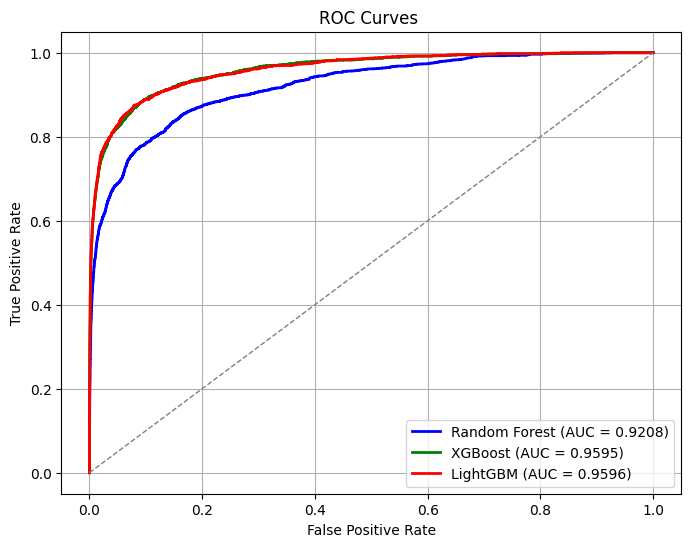

In [ ]:
import pandas as pd
import numpy as np
import gc
import warnings
import os
import joblib
import lightgbm as lgb
import shap
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

def load_data_in_batches(file_path, usecols=None, dtype=None, chunksize=50000):
    chunks = []
    for chunk in pd.read_csv(file_path, usecols=usecols, dtype=dtype, chunksize=chunksize):
        chunk = chunk.dropna(axis=1, how='all')
        chunks.append(chunk)
        del chunk
        gc.collect()
    return pd.concat(chunks, axis=0)

def load_filtered_data(file_path, filter_ids):
    chunks = []
    for chunk in pd.read_csv(file_path, chunksize=50000):
        chunk = chunk[chunk['TransactionID'].isin(filter_ids)]
        if not chunk.empty:
            chunks.append(chunk)
        del chunk
        gc.collect()
    return pd.concat(chunks, axis=0) if chunks else pd.DataFrame()

base_cols = ['TransactionID', 'isFraud']
train_trans = load_data_in_batches("train_transaction.csv", usecols=base_cols)
train_id = load_data_in_batches("train_identity.csv", usecols=['TransactionID'])

train_df = train_trans.merge(train_id, on='TransactionID', how='inner')
required_ids = train_df['TransactionID'].unique()
del train_trans, train_id, train_df
gc.collect()

train_trans = load_filtered_data("train_transaction.csv", required_ids)
train_id = load_filtered_data("train_identity.csv", required_ids)
train_df = train_trans.merge(train_id, on='TransactionID', how='left')

test_trans = load_data_in_batches("test_transaction.csv")
test_id = load_data_in_batches("test_identity.csv")
test_df = test_trans.merge(test_id, on='TransactionID', how='left')

del train_trans, train_id, test_trans, test_id
gc.collect()

print(f"Train shape: {train_df.shape} | Test shape: {test_df.shape}")

# Preprocessing
y = train_df['isFraud'].values
test_ids = test_df['TransactionID'].values
train_df = train_df.drop(columns=['TransactionID', 'isFraud'])
test_df = test_df.drop(columns=['TransactionID'])

def optimize_numeric(df):
    num_cols = df.select_dtypes(include='number').columns
    for col in num_cols:
        df[col] = pd.to_numeric(df[col], downcast='float')
        df[col] = df[col].fillna(df[col].median())
    return df

def optimize_categorical(df):
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in cat_cols:
        df[col] = df[col].fillna('missing').astype('category').cat.codes
        df[col] = pd.to_numeric(df[col], downcast='integer')
    return df

for df in [train_df, test_df]:
    for i in range(0, len(df.columns), 50):
        cols = df.columns[i:i+50]
        temp_df = df[cols]
        temp_df = optimize_numeric(temp_df)
        temp_df = optimize_categorical(temp_df)
        df[cols] = temp_df
        del temp_df
        gc.collect()

# Feature Engineering
print("Adding behavioral features...")
for df in [train_df, test_df]:
    df['TransactionAmt_to_mean'] = df['TransactionAmt'] / (df['TransactionAmt'].mean() + 1e-9)
    df['TransactionAmt_to_std'] = df['TransactionAmt'] / (df['TransactionAmt'].std() + 1e-9)
    if 'ProductCD' in df.columns:
        df['ProductCD_freq'] = df.groupby('ProductCD')['ProductCD'].transform('count')
    if 'TransactionDT' in df.columns:
        df['hour'] = (df['TransactionDT'] // 3600) % 24

# Feature Selection 
print("Feature selection...")
shared_cols = train_df.columns.intersection(test_df.columns)
train_df = train_df[shared_cols]
test_df = test_df[shared_cols]

var_thresh = VarianceThreshold(threshold=0.01)
var_thresh.fit(train_df)
selected_cols = train_df.columns[var_thresh.get_support()]
train_df = train_df[selected_cols]
test_df = test_df[selected_cols]

scaler = StandardScaler()
train_df_scaled = scaler.fit_transform(train_df)
test_df_scaled = scaler.transform(test_df)

def evaluate_model(model, X_train, X_val, y_train, y_val):
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, preds)
    return auc, preds

print("\nCreating balanced and unbalanced training sets...")
X_train, X_val, y_train, y_val = train_test_split(train_df, y, test_size=0.2, stratify=y, random_state=42)

# undersampling
rus = RandomUnderSampler(random_state=42)
X_train_bal, y_train_bal = rus.fit_resample(X_train, y_train)

# oversampling (SMOTE)
smote = SMOTE(random_state=42)
X_train_ovr, y_train_ovr = smote.fit_resample(X_train, y_train)

rf = RandomForestClassifier(n_estimators=100, max_depth=7, class_weight='balanced', random_state=42, n_jobs=-1)
rf_auc_unbalanced, rf_preds = evaluate_model(rf, X_train, X_val, y_train, y_val)
rf_auc_balanced, _ = evaluate_model(rf, X_train_bal, X_val, y_train_bal, y_val)
print(f"Random Forest AUC (unbalanced): {rf_auc_unbalanced:.4f}")
print(f"Random Forest AUC (balanced):   {rf_auc_balanced:.4f}")

xgb_unbalanced = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, scale_pos_weight=(len(y_train)-y_train.sum())/y_train.sum(), random_state=42, n_jobs=-1, tree_method='hist')
xgb_balanced = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, n_jobs=-1, tree_method='hist')

xgb_auc_unbalanced, xgb_preds = evaluate_model(xgb_unbalanced, X_train, X_val, y_train, y_val)
xgb_auc_balanced, _ = evaluate_model(xgb_balanced, X_train_bal, X_val, y_train_bal, y_val)
print(f"XGBoost AUC (unbalanced): {xgb_auc_unbalanced:.4f}")
print(f"XGBoost AUC (balanced):   {xgb_auc_balanced:.4f}")

lgb_train_data = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
lgb_val_data = lgb.Dataset(X_val, label=y_val, reference=lgb_train_data, free_raw_data=False)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'seed': 42,
    'max_depth': 5,
    'scale_pos_weight': (len(y_train)-y_train.sum())/y_train.sum()
}
lgbm = lgb.train(params, lgb_train_data, valid_sets=[lgb_val_data], callbacks=[lgb.early_stopping(20)], num_boost_round=200)
lgbm_preds = lgbm.predict(X_val)
lgbm_auc = roc_auc_score(y_val, lgbm_preds)
print(f"LightGBM AUC: {lgbm_auc:.4f}")

# SHAP
print("\nGenerating SHAP explanations for LightGBM...")
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_val[:1000])
shap.summary_plot(shap_values, X_val.iloc[:1000])

print("\nEnsembling predictions for final test predictions...")
rf.fit(X_train, y_train)
rf_test_preds = rf.predict_proba(test_df)[:,1]
xgb_unbalanced.fit(X_train, y_train)
xgb_test_preds = xgb_unbalanced.predict_proba(test_df)[:,1]
lgbm_test_preds = lgbm.predict(test_df)

final_test_preds = 0.4 * lgbm_test_preds + 0.3 * xgb_test_preds + 0.3 * rf_test_preds

submission = pd.DataFrame({
    'TransactionID': test_ids,
    'isFraud': final_test_preds
})
submission.to_csv("ensemble_submission.csv", index=False)

print("\n🎯 Summary of Results:")
print(f"Random Forest  AUC (unbalanced): {rf_auc_unbalanced:.4f}")
print(f"Random Forest  AUC (balanced):   {rf_auc_balanced:.4f}")
print(f"XGBoost        AUC (unbalanced): {xgb_auc_unbalanced:.4f}")
print(f"XGBoost        AUC (balanced):   {xgb_auc_balanced:.4f}")
print(f"LightGBM       AUC:              {lgbm_auc:.4f}")
print("\nSubmission saved to 'ensemble_submission.csv'.")

# PLot curve
fpr_rf, tpr_rf, _ = roc_curve(y_val, rf_preds)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_val, xgb_preds)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_lgbm, tpr_lgbm, _ = roc_curve(y_val, lgbm_preds)
roc_auc_lgbm = auc(fpr_lgbm, tpr_lgbm)

plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.4f})')
plt.plot(fpr_xgb, tpr_xgb, color='green', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.4f})')
plt.plot(fpr_lgbm, tpr_lgbm, color='red', lw=2, label=f'LightGBM (AUC = {roc_auc_lgbm:.4f})')
plt.plot([0,1], [0,1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves ')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
